In [1]:
'''
This notebook expects the data to be in the "CL class project materials" folder in the root folder
Install the pandas, numpy, nltk, empath libraries atleast before running this
'''

import pandas as pd
import numpy as np
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import  KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from collections import Counter
import re
import string
import nltk
from nltk.corpus import stopwords 
from imblearn.over_sampling import SMOTE, RandomOverSampler
nltk.download('stopwords')

from tqdm import tqdm

from empath import Empath
from scipy import sparse


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prashant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import re
import string

'''
Helper functions
'''
def normalize_tokens(tokenlist):
    normalized_tokens = [token.lower().replace('_','+') for token in tokenlist   
                             if re.search('[^\s]', token) is not None            
                             and not token.startswith("@")                       
                        ]
    return normalized_tokens        

def ngrams(tokens, n):
    return [tokens[i:i+n] for i in range(len(tokens)-n+1)]

def filter_punctuation_bigrams(ngrams):
    punct = string.punctuation
    return [ngram   for ngram in ngrams   if ngram[0] not in punct and ngram[1] not in punct]

def filter_stopword_bigrams(ngrams, stopwords):
    result = [ngram   for ngram in ngrams   if ngram[0] not in stopwords and ngram[1] not in stopwords]
    return result

def whitespace_tokenizer(line):
    return line.split() 

In [3]:
'''
Helper functions for convert text lines to features
'''


nlp = spacy.load('en_core_web_sm')    


def convert_lines_to_feature_strings(line, stopwords, remove_stopword_bigrams=True):
    line = line.translate(str.maketrans('', '', string.punctuation))
    spacy_analysis = nlp(line)
    spacy_tokens = [token.orth_ for token in spacy_analysis]
    normalized_tokens = normalize_tokens(spacy_tokens)

    unigrams          = [token   for token in normalized_tokens
                             if token not in stopwords and token not in string.punctuation]

    bigrams = []
    bigram_tokens     = ["_".join(bigram) for bigram in bigrams]
    bigrams           = ngrams(normalized_tokens, 2) 
    bigrams           = filter_punctuation_bigrams(bigrams)
    if remove_stopword_bigrams:
        bigrams = filter_stopword_bigrams(bigrams, stopwords)
    bigram_tokens = ["_".join(bigram) for bigram in bigrams]
    feature_string = " ".join ([" ".join(unigrams)," ".join(bigram_tokens)])
    return feature_string




def convert_text_into_features(X, stopwords_arg, analyzefn="word", range=(1,2), vocabulary=None):
    training_vectorizer = CountVectorizer(stop_words=stopwords_arg,
                                          analyzer=analyzefn,
                                          lowercase=True,
                                          ngram_range=range,
                                          vocabulary=vocabulary)
    X_features = training_vectorizer.fit_transform(X)
    return X_features, training_vectorizer

In [4]:
lexicon = Empath()
'''
Convert text to emotion score features
'''
def line_to_emotion_features(lines, lexicon, categories=["negative_emotion", "positive_emotion","pain","poor","disappointment"], normalize=False):
    scores = []
    for line in lines:
        score_dict = lexicon.analyze(line, categories=categories, normalize=normalize)
        if score_dict:
            score = [score_dict[cat] for cat in categories]
        else:
            score = [0 for cat in categories]
        scores.append(score)
    return sparse.csr_matrix(np.array(scores))

In [6]:
#!pip3.7 install empath
'''
Stub block
'''
text='the cool cat is in the box'

print(text)
text = text.translate(str.maketrans('', '', string.punctuation))
print(text)
spacy_analysis = nlp(text)
spacy_tokens = [token.orth_ for token in spacy_analysis]
spacy_nouns = [x for x in spacy_analysis.noun_chunks]
print(spacy_nouns)
normalized_tokens = normalize_tokens(spacy_tokens)


lexicon = Empath()

lines=['what the fuck','i will kill myself','i love cocaine']

#lines.apply(line_to_emotion_features, args=(lexicon, ["negative_emotion", "positive_emotion"]))

line_to_emotion_features(lines, lexicon)

array([[0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [5]:
labels_df = pd.read_csv("CL class project materials/umd_reddit_suicidewatch_dataset_v2/crowd/train/crowd_train.csv")

labels_df.head()

,user_id,label
0,40130,a
1,19368,a
2,20841,a
3,8720,a
4,32730,a


In [6]:
posts_df = pd.read_csv("CL class project materials/umd_reddit_suicidewatch_dataset_v2/crowd/train/shared_task_posts.csv")

posts_df.head()

,post_id,user_id,timestamp,subreddit,post_title,post_body
0,wfimt,22002,1342075703,GetMotivated,[real] motivation,This is my first post on reddit. Some time ago...
1,1bsqv3,22002,1365261010,leagueoflegends,simple question about transfering acc to anoth...,Hi.. What will happen with my ranked rating? I...
2,1buqml,22002,1365345637,seduction,_PERSON_ up ever (crosspost from r/GetMotivated,NaN
3,1dr0xf,22002,1367787358,leagueoflegends,simple question: Did you get unnbaned?,Hi. Simple question. Did you get unban from a ...
4,1e0noi,22002,1368125785,leagueoflegends,I can't win. Why... and it's noy my fault.,Hi... Am playing at Eu west... am diamond 5 ri...


In [7]:
train_data = pd.merge(posts_df, labels_df, on=["user_id"])
train_data = train_data.drop(["post_id", "timestamp", "subreddit"], axis=1)
train_data = train_data.dropna()
train_data["binary_label"] = train_data.label.map({"a" : 0, "b" : 0, "c" : 0, "d" : 1})

In [8]:
train_data.count()

user_id         16601
post_title      16601
post_body       16601
label           16601
binary_label    16601
dtype: int64

In [9]:
'''
Add a "features" column which is unigram and bigram features
'''
stop_words = set(stopwords.words('english'))

train_data['features'] = train_data['post_body'].apply(convert_lines_to_feature_strings, args=(stop_words, True))

In [10]:
'''
LLR implementation to include the N best uni/bigram features
'''

pos_counter = Counter()
for post in train_data['features'][train_data['binary_label'] == 1]:
    for x in post.split(' '):
        pos_counter[x] += 1
        
neg_counter = Counter()
for post in train_data['features'][train_data['binary_label'] == 0]:
    for x in post.split(' '):
        neg_counter[x] += 1

import llr


diff = llr.llr_compare(pos_counter, neg_counter)
ranked = sorted(diff.items(), key=lambda x: x[1])

N = 5000

vocab = []

print("\nMore in negative")
for k,v in ranked[:N]:
    vocab.append(k)

print("\nMore in postive")
for k,v in ranked[-N:]:
    vocab.append(k)


More in negative

More in postive


In [11]:
X = train_data['features']
y = train_data['binary_label']


'''
Vectorize data
'''


X_vec, training_vectorizer = convert_text_into_features(X, stopwords_arg= stop_words, analyzefn=whitespace_tokenizer, range=(1,2), vocabulary=vocab)
X_emo = line_to_emotion_features(X, lexicon=lexicon, categories=["negative_emotion", "positive_emotion"], normalize=False)
X_ft = sparse.hstack((X_vec, X_emo))
#X_ft = X_vec


'''
Resampling using SMOTE for imbalanced dataset
'''
X_resampled, y_resampled = SMOTE().fit_resample(X_ft, y)
print("Before resample counts: {}".format(Counter(y)))
print("After resample counts: {}".format(Counter(y_resampled)))


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

lr_classifier = LogisticRegression(solver='liblinear')
svc_classifier = SVC(kernel='linear')

lr_classifier.fit(X_train, y_train)

print("Classifying test data using LR")
predicted_labels = lr_classifier.predict(X_test)
print('Accuracy  = {}'.format(metrics.accuracy_score(predicted_labels,  y_test)))
for label in [0, 1]:
    print('Precision for label {} = {}'.format(label, metrics.precision_score(predicted_labels, y_test, pos_label=label)))
    print('Recall    for label {} = {}'.format(label, metrics.recall_score(predicted_labels,    y_test, pos_label=label)))
    
#metrics.plot_confusion_matrix(lr_classifier, X_train.toarray(), y_train)

Before resample counts: Counter({0: 9495, 1: 7106})
After resample counts: Counter({0: 9495, 1: 9495})
Classifying test data using LR
Accuracy  = 0.7427593470247499
Precision for label 0 = 0.6811671087533157
Recall    for label 0 = 0.7734939759036145
Precision for label 1 = 0.803450078410873
Recall    for label 1 = 0.7188961646398503


In [12]:
'''
K-Folds
'''
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
accuracy_scores = cross_val_score(lr_classifier, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
print("accuracy scores = {}, mean = {}, stdev = {}".format(
        accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)), flush=True)

accuracy scores = [0.7153669  0.72030273 0.72119816 0.71757735 0.72251481], mean = 0.7193919901495611, stdev = 0.0025821690999201755


In [13]:
'''
Random Forest Classifier
'''
rf_classifier = RandomForestClassifier(max_depth=4, random_state=0)

rf_classifier.fit(X_train, y_train)

print("Classifying test data using Random Forest")
predicted_labels = rf_classifier.predict(X_test)
print('Accuracy  = {}'.format(metrics.accuracy_score(predicted_labels,  y_test)))
for label in [0, 1]:
    print('Precision for label {} = {}'.format(label, metrics.precision_score(predicted_labels, y_test, pos_label=label)))
    print('Recall    for label {} = {}'.format(label, metrics.recall_score(predicted_labels,    y_test, pos_label=label)))
    
rf_classifier = RandomForestClassifier(max_depth=4, random_state=0)

accuracy_scores = cross_val_score(rf_classifier, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
print("accuracy scores = {}, mean = {}, stdev = {}".format(
        accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)), flush=True)

Classifying test data using Random Forest
Accuracy  = 0.6187467087941022
Precision for label 0 = 0.5262599469496021
Recall    for label 0 = 0.6412411118293472
Precision for label 1 = 0.7098797699947726
Recall    for label 1 = 0.6032874278098623
accuracy scores = [0.61204344 0.64100033 0.62277814 0.62903226 0.62574062], mean = 0.6261189569608693, stdev = 0.009374081734716162


Classifying test data using Random Forest
Accuracy  = 0.7630331753554502
Precision for label 0 = 0.5522546419098143
Recall    for label 0 = 0.9489516864175023
Precision for label 1 = 0.970726607422896
Recall    for label 1 = 0.6875231395779341


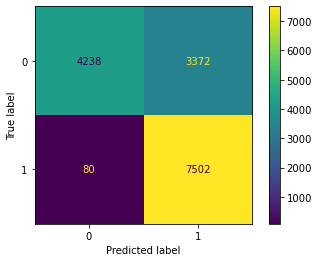

In [14]:
'''
Naive Bayes
'''
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()
nb_classifier.fit(X_train.toarray(), y_train)

print("Classifying test data using Random Forest")
predicted_labels = nb_classifier.predict(X_test.toarray())
print('Accuracy  = {}'.format(metrics.accuracy_score(predicted_labels,  y_test)))
for label in [0, 1]:
    print('Precision for label {} = {}'.format(label, metrics.precision_score(predicted_labels, y_test, pos_label=label)))
    print('Recall    for label {} = {}'.format(label, metrics.recall_score(predicted_labels,    y_test, pos_label=label)))

    '''
nb_classifier = GaussianNB()

accuracy_scores = cross_val_score(nb_classifier, X_train.toarray(), y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
print("accuracy scores = {}, mean = {}, stdev = {}".format(
        accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)), flush=True)
        '''
    
metrics.plot_confusion_matrix(nb_classifier, X_train.toarray(), y_train)

In [116]:
svc_classifier.fit(X_train, y_train)

print("Classifying test data using SVC")
predicted_labels = svc_classifier.predict(X_test)
print('Accuracy  = {}'.format(metrics.accuracy_score(predicted_labels,  y_test)))
for label in [0, 1]:
    print('Precision for label {} = {}'.format(label, metrics.precision_score(predicted_labels, y_test, pos_label=label)))
    print('Recall    for label {} = {}'.format(label, metrics.recall_score(predicted_labels,    y_test, pos_label=label)))
    
svc_classifier = SVC(kernel='linear')

accuracy_scores = cross_val_score(svc_classifier, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
print("accuracy scores = {}, mean = {}, stdev = {}".format(
        accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)), flush=True)

Classifying test data using SVC
Accuracy  = 0.6648235913638757
Precision for label 0 = 0.47586206896551725
Recall    for label 0 = 0.7588832487309645
Precision for label 1 = 0.851019341348667
Recall    for label 1 = 0.6223241590214067
accuracy scores = [0.65712405 0.65876933 0.64845293 0.64812377 0.65371955], mean = 0.6532379267027003, stdev = 0.0043584684051423935
